# Мережний аналіз часового ряду

In [1]:
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import yfinance as yf
from ts2vg import NaturalVG, HorizontalVG
import networkx as nx
from tqdm import tqdm
from scipy.spatial import distance
import neurokit2 as nk

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
plt.style.use(['classic'])

params = {
    'figure.figsize': (15, 8), 
    'axes.labelsize': 36,
    'axes.titlesize': 36, 
    'font.size': 36, 
    'legend.fontsize': 36, 
    'xtick.labelsize': 32, 
    'ytick.labelsize': 32, 
    'lines.linewidth': 2,
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'axes.titlesize': 'small',
    'font.family': 'Times New Roman',
    'savefig.dpi': 1000
}

plt.rcParams.update(params)

xlabel = 'time, days'

In [3]:
def recurrence_net(time_ser, rec_thr, rec_inc, dim, tau, dist_type='euclidien'):
    time_series = nk.complexity_embedding(time_ser, dimension=dim, delay=tau)
    rp = (distance.cdist(time_series, time_series, dist_type) <= rec_thr).astype(int)
    adj_matrix_RN = rp
    np.fill_diagonal(adj_matrix_RN, 0)

    rec_nw = nx.from_numpy_matrix(adj_matrix_RN)
    
    while not nx.is_connected(rec_nw):
        rec_thr += rec_inc
        
        rp = (distance.cdist(time_series, time_series, dist_type) <= rec_thr).astype(int)
        adj_matrix_RN = rp
        np.fill_diagonal(adj_matrix_RN, 0)
        
        rec_nw = nx.from_numpy_matrix(adj_matrix_RN) 
    
    return rec_nw

def node_positions_recurrence_net(ts, xs):
    return {i: (xs[i], ts[i]) for i in range(len(ts))}

# Зчитування з Yahoo Finance

In [4]:
symbol = "^DJI"
symbol_plot = "^DJI"

symbol_for_graph = "^DJI"
symbol_for_graph_plot = symbol_for_graph.split('.')[0]

start = "2004-01-02"
end = "2022-10-18"

data = yf.download(symbol, start, end)
time_ser = data['Adj Close'].copy()
for_graph = data['Adj Close'].copy()

date_in_num = mdates.date2num(time_ser.index)

np.savetxt(f'{symbol}_initial_time_series.txt', time_ser.values)

[*********************100%***********************]  1 of 1 completed


# Зчитування з txt файлів

In [4]:
symbol = "abs7_1_2_2.txt" #назва файлу 1, що зчитуємо
symbol_plot = "abs7_1_2_2.txt"

In [5]:
with open(symbol, 'r') as f: #зчитуємо файл
    time_ser = [line.strip('\n') for line in f.readlines()]
    time_ser = [float(line) for line in time_ser if line != '']
time_ser = pd.Series(time_ser) #перетворюємо на масив pandas для використання вбудованих функцій знаходження приб., видалення нульових значень
date_in_num = time_ser.index 

In [6]:
symbol_for_graph = "abs7_1_2_2.txt" #для графіки
symbol_for_graph_plot = symbol_for_graph.split('.')[0]

In [7]:
with open(symbol_for_graph, 'r') as f_for_graph: #зчитуємо файл
    for_graph = [line.strip('\n') for line in f_for_graph.readlines()]
    for_graph = [float(line) for line in for_graph if line != '']
for_graph = pd.Series(for_graph) #перетворюємо на масив pandas для використання вбудованих функцій знаходження приб., видалення нульових значень

# Виведення графіку досліджуваного ряду

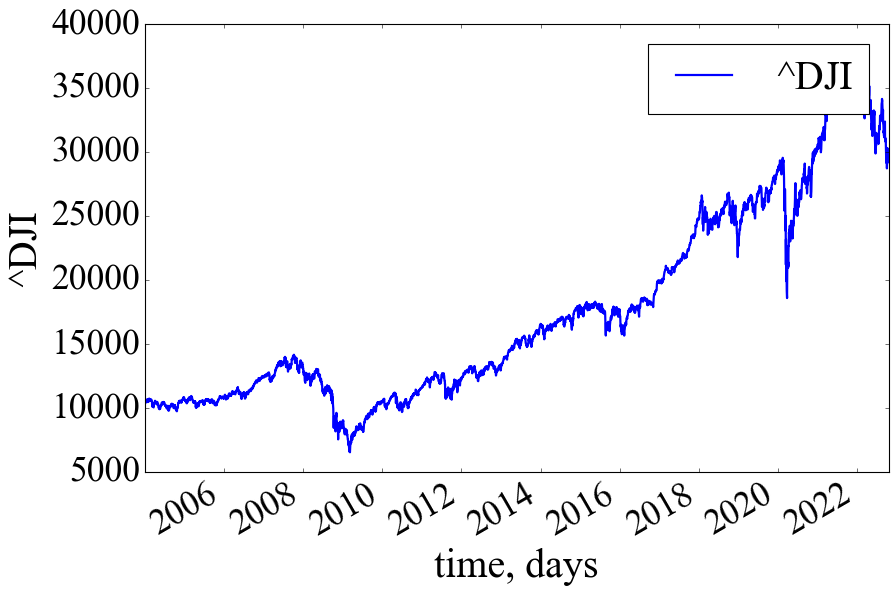

In [5]:
fig, ax = plt.subplots()
time_ser.plot(figsize=(12,8), xlabel=xlabel, ylabel=symbol_plot)
ax.legend([symbol_for_graph_plot]);

plt.savefig(f'{symbol}.jpg')
plt.show()

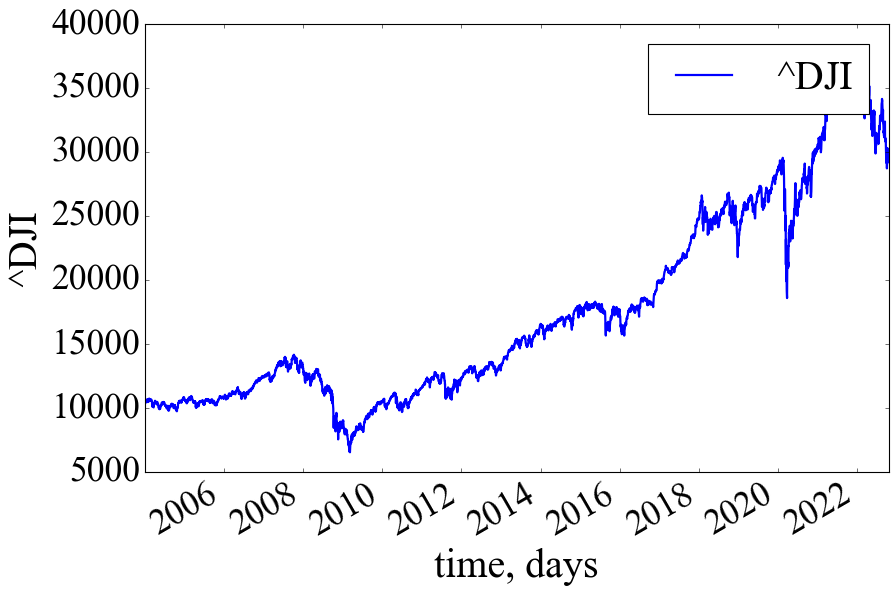

In [6]:
fig, ax = plt.subplots()
for_graph.plot(figsize=(12,8), xlabel=xlabel, ylabel=symbol_for_graph_plot)
ax.legend([symbol_for_graph_plot]);

plt.savefig(f'{symbol_for_graph}.jpg')
plt.show()

# Задання параметрів досліджуваного графу

In [7]:
window = 500 #розмір вікна
tstep = 50 #крок вікна
graph_type = 'classic' # тип графу: classic, horizontal, recurrent

ret_type = 1 #вид ряду: 1 - вихідний, 2 - детрендований (різниця між теп. значенням та попереднім)
                        # 3 - прибутковості звичайні, 4 - стандартизовані прибутковості, 5 - абсолютні значення (волатильності)
                        # 6 - стандартизований ряд


# Для рекурентного графа 
d_e = 3 # розмірність
tau = 1 # часова затримка
eps = 0.1 # радіус
eps_inc = 0.1 # крок нарощування радіуса для повної зв'язності графа
dist = 'euclidean' # canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, 
                   # ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, 
                   # ‘jensenshannon’, ‘kulsinski’, ‘kulczynski1’, ‘mahalanobis’, 
                   # ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, 
                   # ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.

length = len(time_ser)

# Побудова графу

In [8]:
index_begin = 1500
index_end = 3500

for_graph_plot = time_ser.copy()

if ret_type == 1:
    pass
elif ret_type == 2:
    for_graph_plot = for_graph_plot.diff()
elif ret_type == 3:
    for_graph_plot = for_graph_plot.pct_change()
elif ret_type == 4:
    for_graph_plot = for_graph_plot.pct_change()
    for_graph_plot -= for_graph_plot.mean()
    for_graph_plot /= for_graph_plot.std()
elif ret_type == 5: 
    for_graph_plot = for_graph_plot.pct_change()
    for_graph_plot -= for_graph_plot.mean()
    for_graph_plot /= for_graph_plot.std()
    for_graph_plot = for_graph_plot.abs()
elif ret_type == 6:
    for_graph_plot -= for_graph_plot.mean()
    for_graph_plot /= for_graph_plot.std()

for_graph_plot = for_graph_plot.copy().dropna().values

date = date_in_num[index_begin:index_end]

if graph_type == 'classic':
    g = NaturalVG(directed=None).build(for_graph_plot[index_begin:index_end], xs=date)
    pos = g.node_positions()
    nxg = g.as_networkx()
elif graph_type == 'horizontal':
    g = HorizontalVG(directed=None).build(for_graph_plot[index_begin:index_end], xs=date)
    pos = g.node_positions()
    nxg = g.as_networkx()
else:
    g = recurrence_net(for_graph_plot[index_begin:index_end], 
                       rec_thr=eps,
                       rec_inc=eps_inc,
                       dim=d_e, 
                       tau=tau, 
                       dist_type=dist)
    
    pos = node_positions_recurrence_net(for_graph_plot[index_begin:index_end], date)
    nxg = g
    
    


graph_plot_options = {
    'with_labels': False,
    'node_size': 5,
    'node_color': [(0, 0, 0, 1)],
    'edge_color': [(0, 0, 0, 0.15)],
}


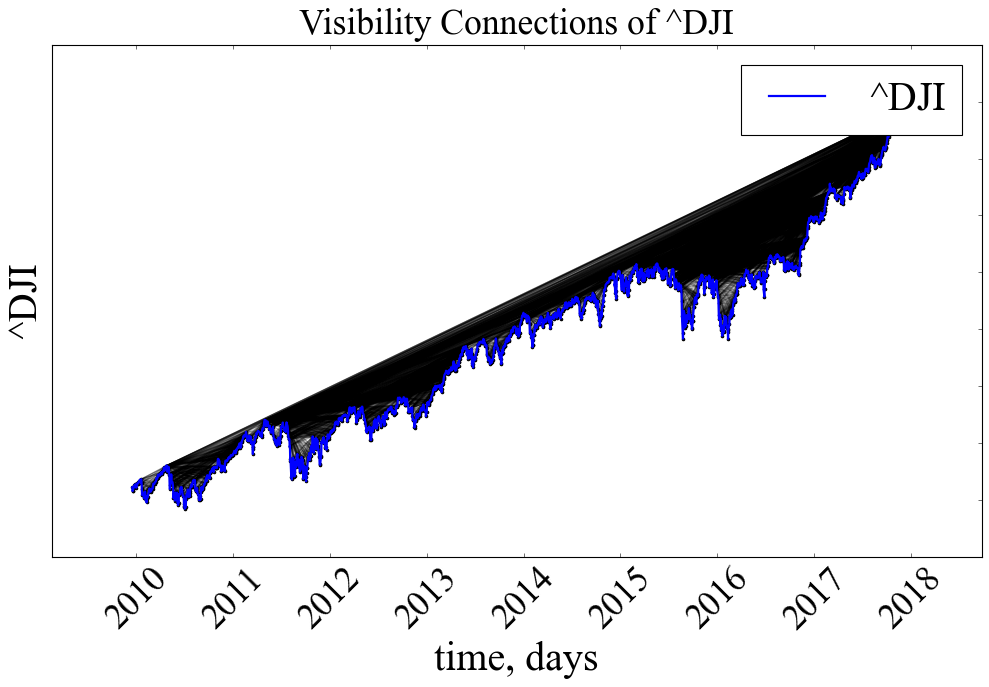

In [9]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

nx.draw_networkx(nxg, ax=ax1, pos=pos, **graph_plot_options)
ax1.tick_params(bottom=True, labelbottom=True)
ax1.plot(time_ser.index[index_begin:index_end], for_graph_plot[index_begin:index_end], label=fr"{symbol_plot}")
ax1.set_title(f'Visibility Connections of {symbol_for_graph_plot}', fontsize=32, pad=10)
ax1.set_xlabel(xlabel)
ax1.set_ylabel(fr"{symbol_for_graph_plot}")
ax1.legend(loc='upper right')
ax1.tick_params(axis='x', labelrotation=45)


plt.savefig(f"Time_ser_connections_symbol={symbol}_idx_beg={index_begin}_idx_end={index_end}_sertype={ret_type}_network_type={graph_type}.jpg", bbox_inches="tight", dpi=1000)
plt.show()

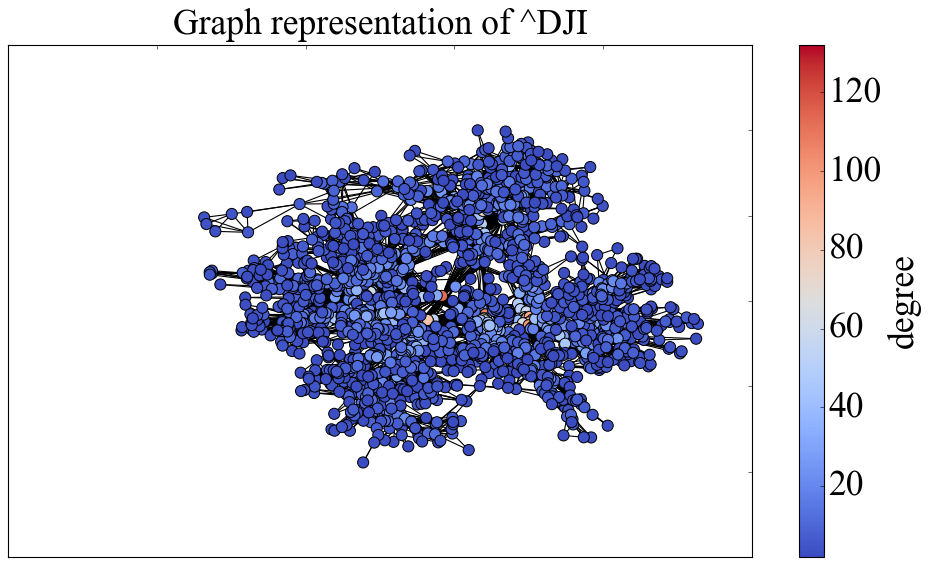

In [10]:
pos = nx.spring_layout(nxg,k=0.15,iterations=100)
# find node near center (0.5,0.5)
dmin = 1
ncenter = 0
for n in pos: #helps in color code nodes
    x, y = pos[n]
    d = (x - 0.5)**2 + (y - 0.5)**2
    if d < dmin:
        ncenter = n
        dmin = d

#color by degree
p = dict(nx.degree(nxg))
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
ax2.set_title(f'Graph representation of {symbol_for_graph_plot}', fontsize=32, pad=10)
nx.draw_networkx_edges(nxg, ax=ax2, pos=pos, nodelist=[ncenter], alpha=1,width=1)
nx.draw_networkx_nodes(nxg, ax=ax2, pos=pos, nodelist=list(p.keys()),
                       node_size=100, edgecolors=None, linewidths=0.9,
                       node_color=list(p.values()),
                       cmap=plt.cm.coolwarm)
        
vmin = np.asarray(list(p.values())).min()
vmax = np.asarray(list(p.values())).max()

sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cb = plt.colorbar(sm, ax=ax2)
cb.set_label('degree', fontsize=32)
#sm.set_array([])
#plt.axis('off')

plt.savefig(f"Graph_representation_symbol={symbol}_idx_beg={index_begin}_idx_end={index_end}_sertype={ret_type}_network_type={graph_type}.jpg", bbox_inches="tight", dpi=1000)
plt.show()

# In window (Spectral)

In [11]:
AlgebraicCon = []
GraphEnergy = []
SpecMoment_3 = []
SpecRadius = []
SpecGap = []
NaturalConnectivity = []

In [12]:
for i in tqdm(range(0,length-window,tstep)):
    fragm = time_ser.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm.diff()
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
    elif ret_type == 5: 
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        fragm = fragm.abs()
    elif ret_type == 6:
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values 
    
    if graph_type == 'classic':
        g = NaturalVG(directed=None).build(fragm)
        pos = g.node_positions()
        nxg = g.as_networkx()
    elif graph_type == 'horizontal':
        g = HorizontalVG(directed=None).build(fragm)
        pos = g.node_positions()
        nxg = g.as_networkx()
    else:
        g = recurrence_net(fragm, rec_thr=eps, rec_inc=eps_inc, dim=d_e, tau=tau, dist_type=dist)
        nxg = g
    
    
    adj_spectrum = np.float64(nx.adjacency_spectrum(nxg)) # спектр власних значень матриці суміжності
    sorted_adj_spectrum = np.sort(adj_spectrum)
    
    alg_con = nx.algebraic_connectivity(nxg, normalized=True, method='tracemin_lu') 
    graph_en = np.sum(np.abs(adj_spectrum))
    spec_gap = sorted_adj_spectrum[-1] - sorted_adj_spectrum[-2]
    spec_rad = np.max(np.abs(adj_spectrum))
    spec_mom_3 = np.mean(adj_spectrum ** 3)
    nat_con = np.log(np.mean(np.exp(adj_spectrum)))
    
    
    AlgebraicCon.append(alg_con)
    GraphEnergy.append(graph_en)
    SpecRadius.append(spec_rad)
    SpecGap.append(spec_gap)
    SpecMoment_3.append(spec_mom_3)
    NaturalConnectivity.append(nat_con)

  0%|          | 0/85 [00:00<?, ?it/s]C:\Users\Andrii\anaconda3\lib\site-packages\networkx\linalg\spectrum.py:110: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return sp.linalg.eigvals(nx.adjacency_matrix(G, weight=weight).todense())
C:\Users\Andrii\AppData\Local\Temp\ipykernel_15784\3225050666.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  adj_spectrum = np.float64(nx.adjacency_spectrum(nxg)) # спектр власних значень матриці суміжності
<class 'networkx.utils.decorators.argmap'> compilation 21:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
100%|██████████| 85/85 [00:11<00:00,  7.16it/s]


In [13]:
np.savetxt(f"algebraic_conn_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", AlgebraicCon)
np.savetxt(f"graph_energy_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", GraphEnergy)
np.savetxt(f"spectral_radius_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", SpecRadius)
np.savetxt(f"spectral_grap_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", SpecGap)
np.savetxt(f"spectral_moment_3_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", SpecMoment_3)
np.savetxt(f"natural_connectivity_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", NaturalConnectivity)

*алгебраїчна зв'язність:* https://networkx.org/documentation/stable/reference/generated/networkx.linalg.algebraicconnectivity.algebraic_connectivity.html

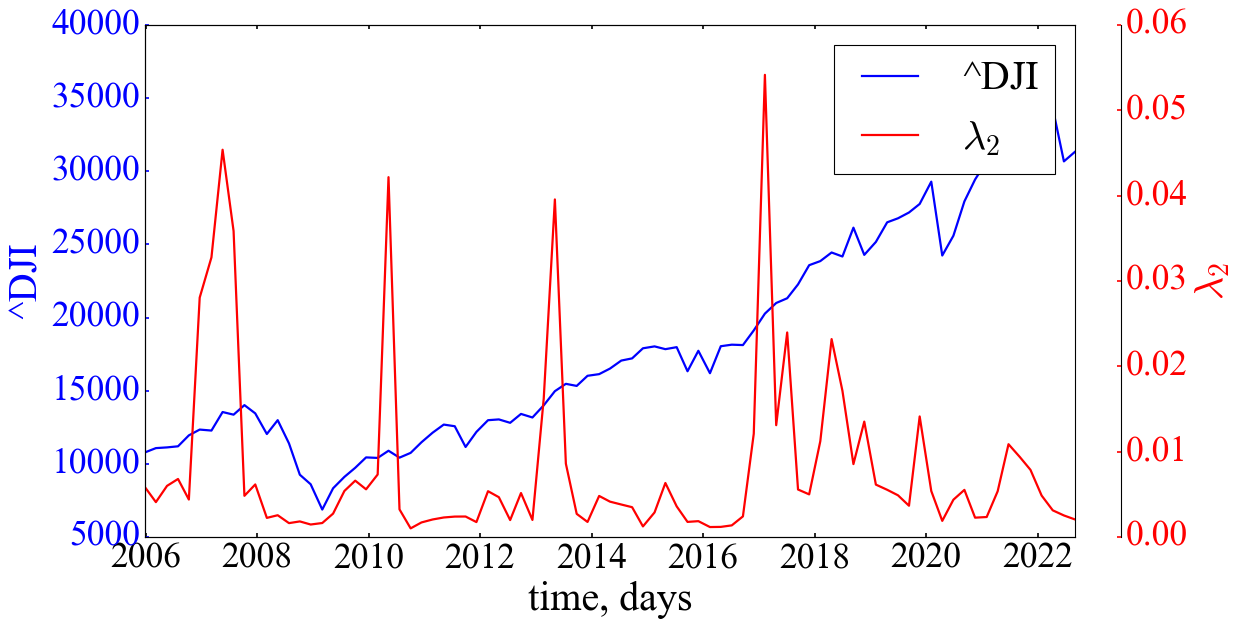

In [14]:
fig, ax = plt.subplots(1, 1)

ax2 = ax.twinx()

ax2.spines.right.set_position(("axes", 1.05))

p1, = ax.plot(time_ser.index[window:length:tstep], for_graph[window:length:tstep], "b-", label=fr"{symbol_for_graph_plot}")
p2, = ax2.plot(time_ser.index[window:length:tstep], AlgebraicCon, "r-", label=r'$\lambda_{2}$')

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph_plot}")
ax2.set_ylabel(r'$\lambda_{2}$')

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax2.legend(handles=[p1, p2], loc='best')

plt.savefig(f"algebraic_conn, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

*енергія графу*: посібник

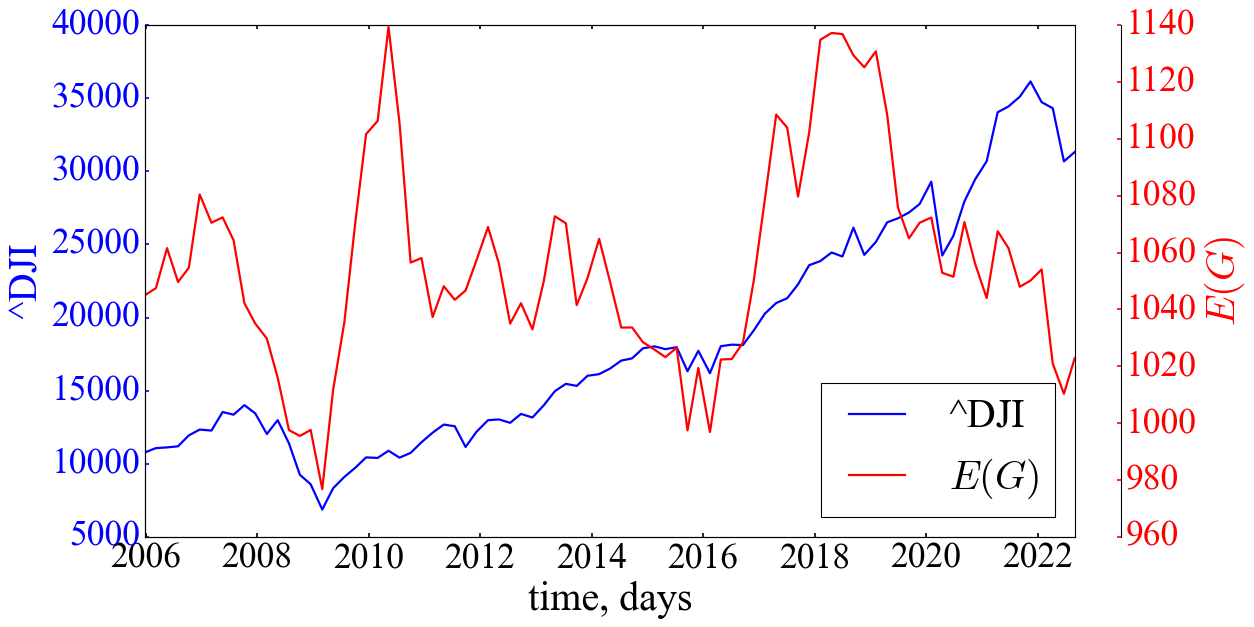

In [15]:
fig, ax = plt.subplots(1, 1)

ax2 = ax.twinx()

ax2.spines.right.set_position(("axes", 1.05))

p1, = ax.plot(time_ser.index[window:length:tstep], for_graph[window:length:tstep], "b-", label=fr"{symbol_for_graph_plot}")
p2, = ax2.plot(time_ser.index[window:length:tstep], GraphEnergy, "r-", label=r'$E(G)$')

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph_plot}")
ax2.set_ylabel(r'$E(G)$')

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax2.legend(handles=[p1, p2], loc='best')

plt.savefig(f"graph_energy, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

*спектральний радіус*: посібник

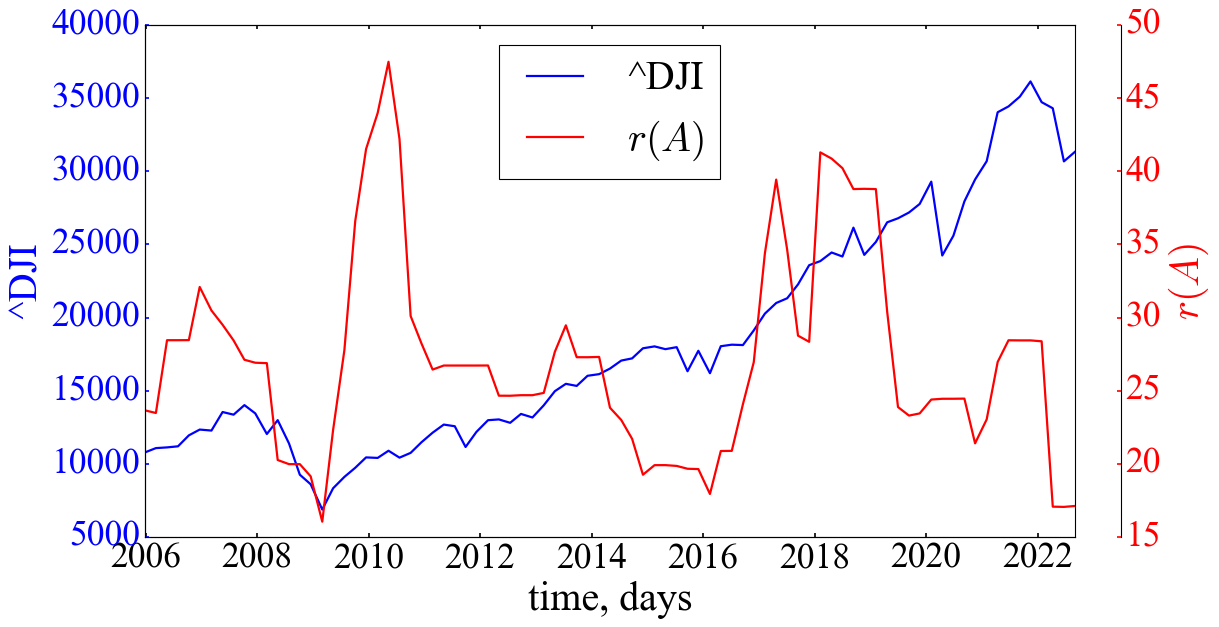

In [16]:
fig, ax = plt.subplots(1, 1)

ax2 = ax.twinx()

ax2.spines.right.set_position(("axes", 1.05))

p1, = ax.plot(time_ser.index[window:length:tstep], for_graph[window:length:tstep], "b-", label=fr"{symbol_for_graph_plot}")
p2, = ax2.plot(time_ser.index[window:length:tstep], SpecRadius, "r-", label=r'$r(A)$')

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph_plot}")
ax2.set_ylabel(r'$r(A)$')

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax2.legend(handles=[p1, p2], loc='best')

plt.savefig(f"spectral_radius, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

*спектральний розрив*: посібник

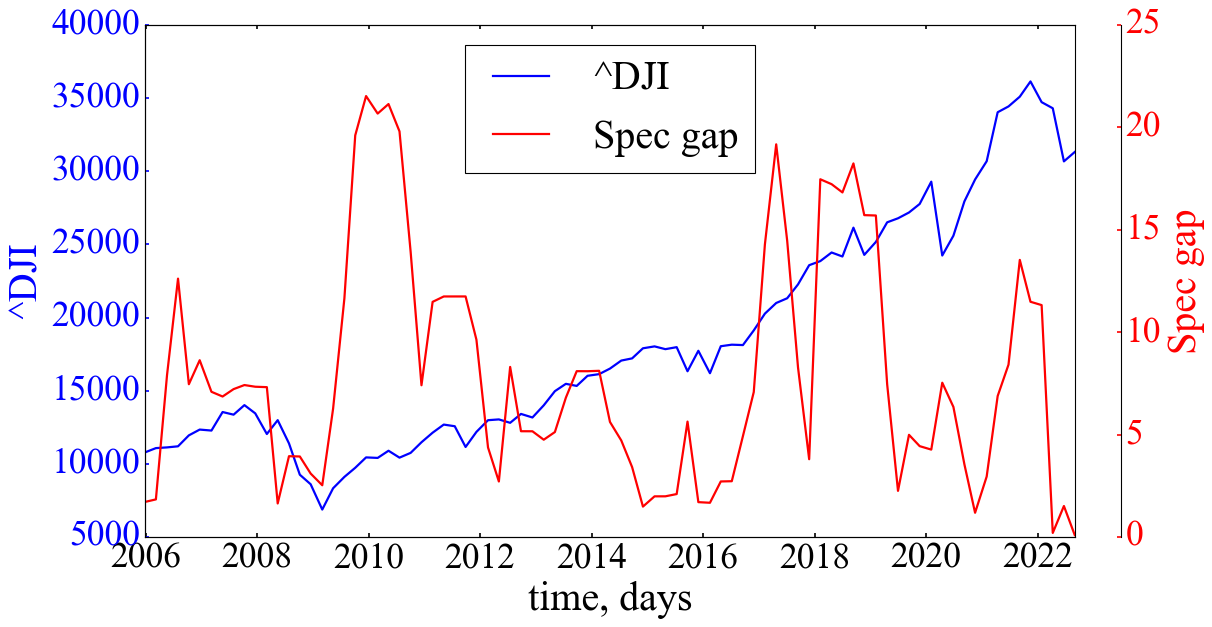

In [17]:
fig, ax = plt.subplots(1, 1)

ax2 = ax.twinx()

ax2.spines.right.set_position(("axes", 1.05))

p1, = ax.plot(time_ser.index[window:length:tstep], for_graph[window:length:tstep], "b-", label=fr"{symbol_for_graph_plot}")
p2, = ax2.plot(time_ser.index[window:length:tstep], SpecGap, "r-", label=r'Spec gap')

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph_plot}")
ax2.set_ylabel(r'Spec gap')

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax2.legend(handles=[p1, p2], loc='best')

plt.savefig(f"spectral_gap, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

*спектральний момент*: посібник

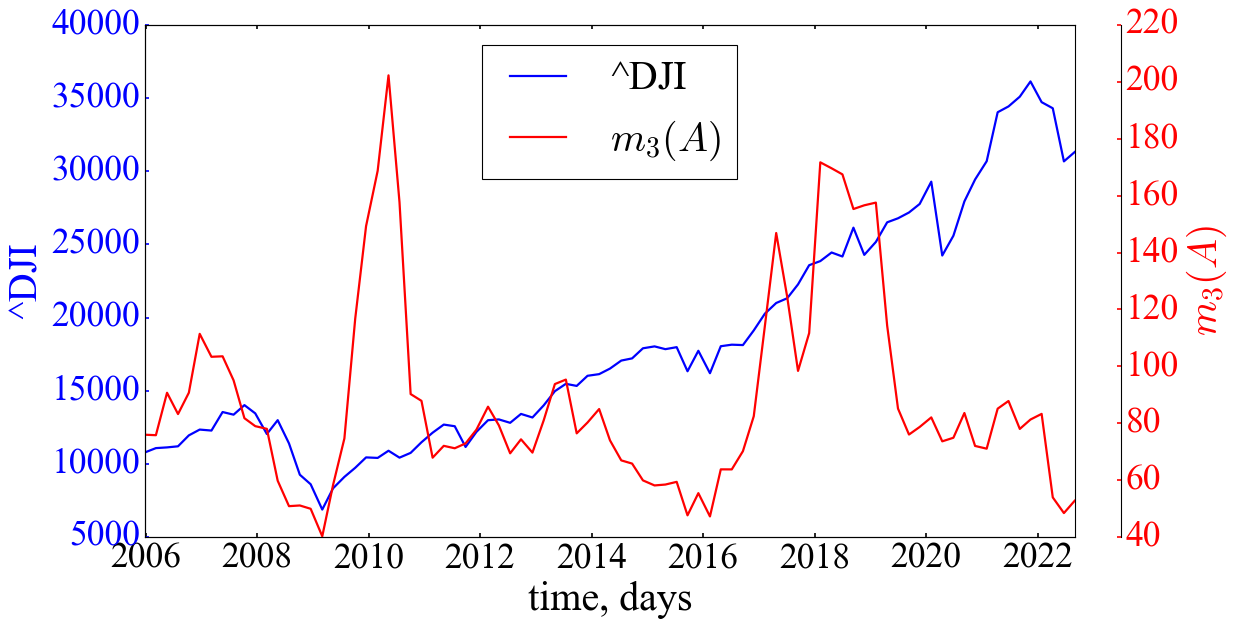

In [18]:
fig, ax = plt.subplots(1, 1)

ax2 = ax.twinx()

ax2.spines.right.set_position(("axes", 1.05))

p1, = ax.plot(time_ser.index[window:length:tstep], for_graph[window:length:tstep], "b-", label=fr"{symbol_for_graph_plot}")
p2, = ax2.plot(time_ser.index[window:length:tstep], SpecMoment_3, "r-", label=r'$m_{3}(A)$')

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph_plot}")
ax2.set_ylabel(r'$m_{3}(A)$')

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax2.legend(handles=[p1, p2], loc='best')

plt.savefig(f"spectral_moment_3, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

*спектральна природна зв'язність:* https://www.researchgate.net/publication/230944853_Natural_Connectivity_of_Complex_Networks

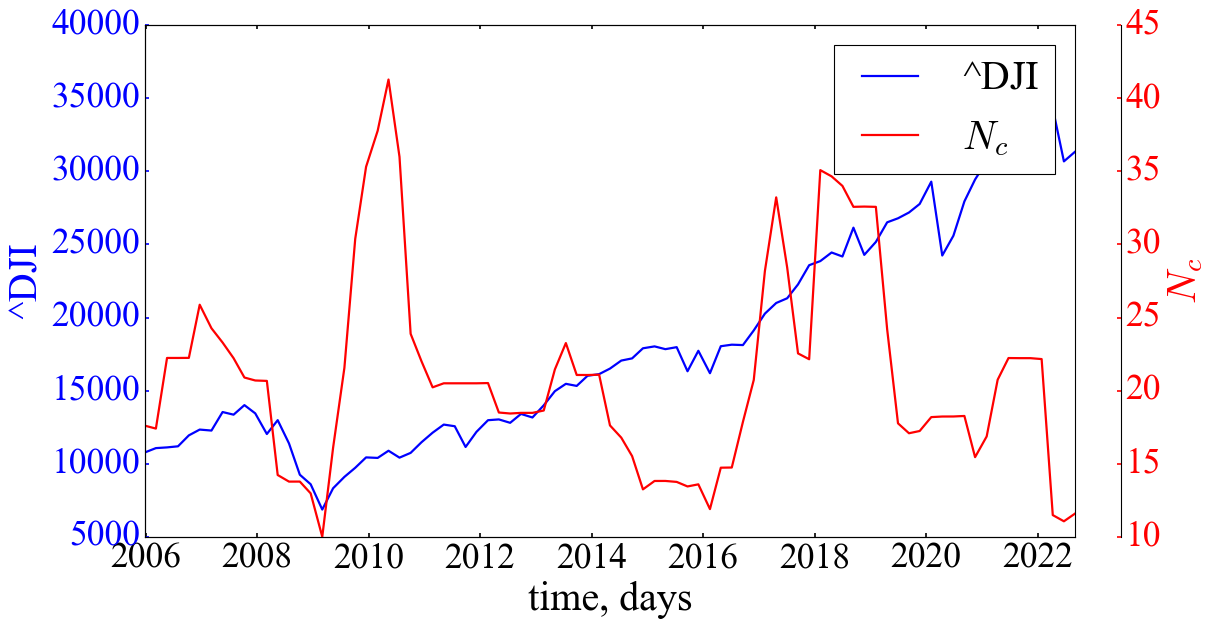

In [19]:
fig, ax = plt.subplots(1, 1)

ax2 = ax.twinx()

ax2.spines.right.set_position(("axes", 1.05))

p1, = ax.plot(time_ser.index[window:length:tstep], for_graph[window:length:tstep], "b-", label=fr"{symbol_for_graph_plot}")
p2, = ax2.plot(time_ser.index[window:length:tstep], NaturalConnectivity, "r-", label=r'$N_{c}$')

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph_plot}")
ax2.set_ylabel(r'$N_{c}$')

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax2.legend(handles=[p1, p2], loc='best')

plt.savefig(f"natural_connectivity, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

# In window (Topological)
## Centrality

In [20]:
DegreeMax = []
GlobalEigenvectorCentrality = []
GlobalClosenessCentrality = []
GlobalInformationCentrality = []
GlobalBetweennessCentrality = []
GlobalLoadCentrality = []
GlobalHarmonicCentrality = []

In [21]:
for i in tqdm(range(0,length-window,tstep)):
    fragm = time_ser.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm.diff()
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
    elif ret_type == 5: 
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        fragm = fragm.abs()
    elif ret_type == 6:
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values 
    
    if graph_type == 'classic':
        g = NaturalVG(directed=None).build(fragm)
        pos = g.node_positions()
        nxg = g.as_networkx()
    elif graph_type == 'horizontal':
        g = HorizontalVG(directed=None).build(fragm)
        pos = g.node_positions()
        nxg = g.as_networkx()
    else:
        g = recurrence_net(fragm, rec_thr=eps, rec_inc=eps_inc, dim=d_e, tau=tau, dist_type=dist)
        nxg = g
    
    deg_max = max(dict(nxg.degree()).values())
    glob_eigenvector_centrality = np.mean(list(nx.eigenvector_centrality_numpy(nxg).values()))
    glob_closeness_centrality = np.mean(list(nx.closeness_centrality(nxg).values()))
    glob_information_centrality = np.mean(list(nx.information_centrality(nxg).values()))
    glob_betweenness_centrality = np.max(list(nx.betweenness_centrality(nxg).values()))
    glob_load_centrality = np.max(list(nx.load_centrality(nxg).values()))
    glob_harm_centrality = np.mean(list(nx.harmonic_centrality(nxg).values()))

    
    DegreeMax.append(deg_max)
    GlobalEigenvectorCentrality.append(glob_eigenvector_centrality)
    GlobalClosenessCentrality.append(glob_closeness_centrality)
    GlobalInformationCentrality.append(glob_information_centrality)
    GlobalBetweennessCentrality.append(glob_betweenness_centrality)
    GlobalLoadCentrality.append(glob_load_centrality)
    GlobalHarmonicCentrality.append(glob_harm_centrality)



100%|██████████| 85/85 [04:32<00:00,  3.21s/it]


In [22]:
np.savetxt(f"DegreeMax_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", DegreeMax)
np.savetxt(f"GlobalEigenvectorCentrality_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", GlobalEigenvectorCentrality)
np.savetxt(f"GlobalClosenessCentrality_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", GlobalClosenessCentrality)
np.savetxt(f"GlobalInformationCentrality_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", GlobalInformationCentrality)
np.savetxt(f"GlobalBetweennessCentrality_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", GlobalBetweennessCentrality)
np.savetxt(f"GlobalLoadCentrality_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", GlobalLoadCentrality)
np.savetxt(f"GlobalHarmonicCentrality_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", GlobalHarmonicCentrality)

*максимальний ступінь вершини:* https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.degree.html#

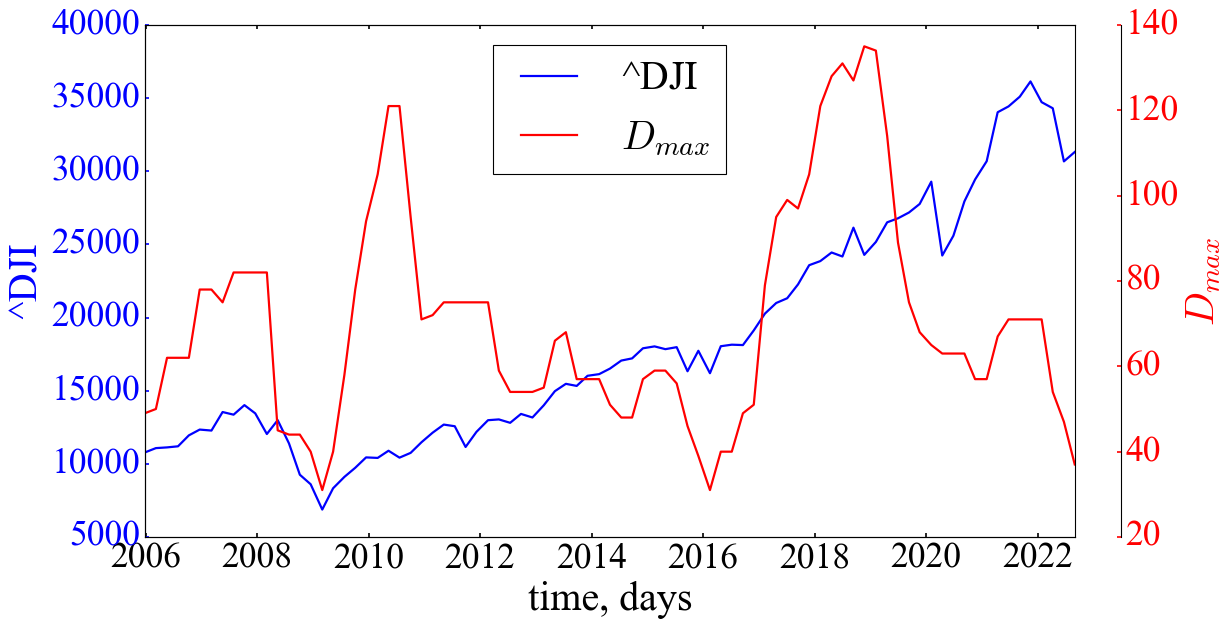

In [23]:
fig, ax = plt.subplots(1, 1)

ax2 = ax.twinx()

ax2.spines.right.set_position(("axes", 1.05))

p1, = ax.plot(time_ser.index[window:length:tstep], for_graph[window:length:tstep], "b-", label=fr"{symbol_for_graph_plot}")
p2, = ax2.plot(time_ser.index[window:length:tstep], DegreeMax, "r-", label=r'$D_{max}$')

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph_plot}")
ax2.set_ylabel(r'$D_{max}$')

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax2.legend(handles=[p1, p2], loc='best')

plt.savefig(f"DegreeMax, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.eigenvector_centrality.html#networkx.algorithms.centrality.eigenvector_centrality

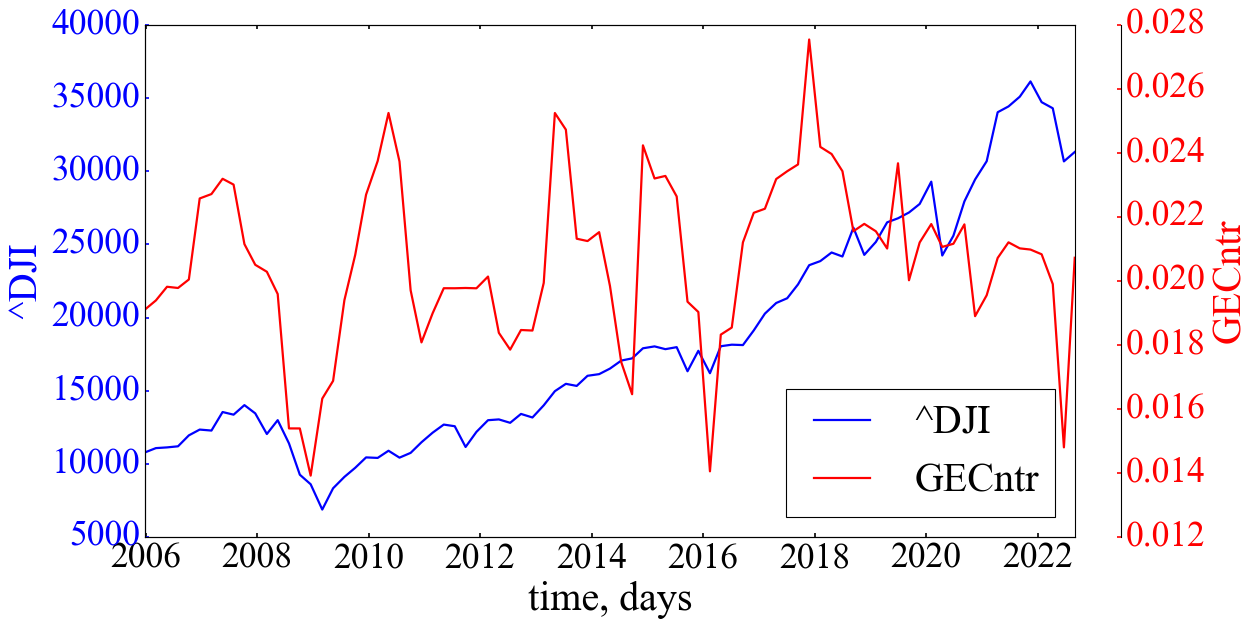

In [24]:
fig, ax = plt.subplots(1, 1)

ax2 = ax.twinx()

ax2.spines.right.set_position(("axes", 1.05))

p1, = ax.plot(time_ser.index[window:length:tstep], for_graph[window:length:tstep], "b-", label=fr"{symbol_for_graph_plot}")
p2, = ax2.plot(time_ser.index[window:length:tstep], GlobalEigenvectorCentrality, "r-", label=r'GECntr')

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph_plot}")
ax2.set_ylabel(r'GECntr')

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax2.legend(handles=[p1, p2], loc='best')

plt.savefig(f"GlobalEigenvectorCentrality, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html#networkx.algorithms.centrality.closeness_centrality

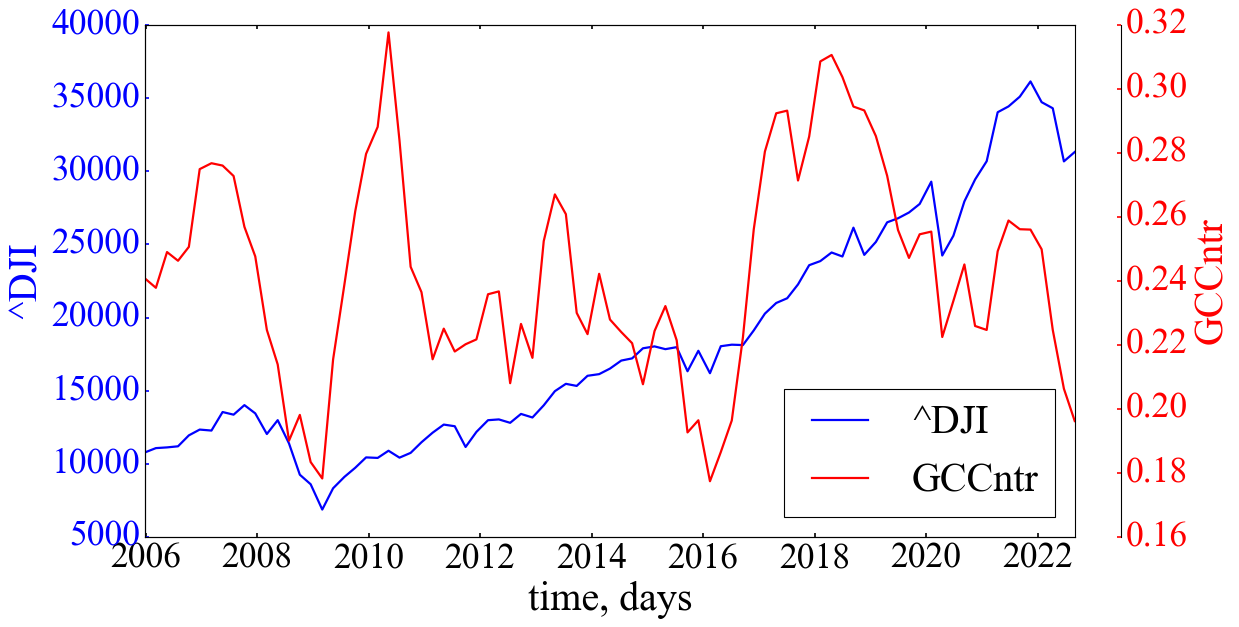

In [25]:
fig, ax = plt.subplots(1, 1)

ax2 = ax.twinx()

ax2.spines.right.set_position(("axes", 1.05))

p1, = ax.plot(time_ser.index[window:length:tstep], for_graph[window:length:tstep], "b-", label=fr"{symbol_for_graph_plot}")
p2, = ax2.plot(time_ser.index[window:length:tstep], GlobalClosenessCentrality, "r-", label=r'GCCntr')

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph_plot}")
ax2.set_ylabel(r'GCCntr')

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax2.legend(handles=[p1, p2], loc='best')

plt.savefig(f"GlobalClosenessCentrality, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.information_centrality.html#networkx.algorithms.centrality.information_centrality

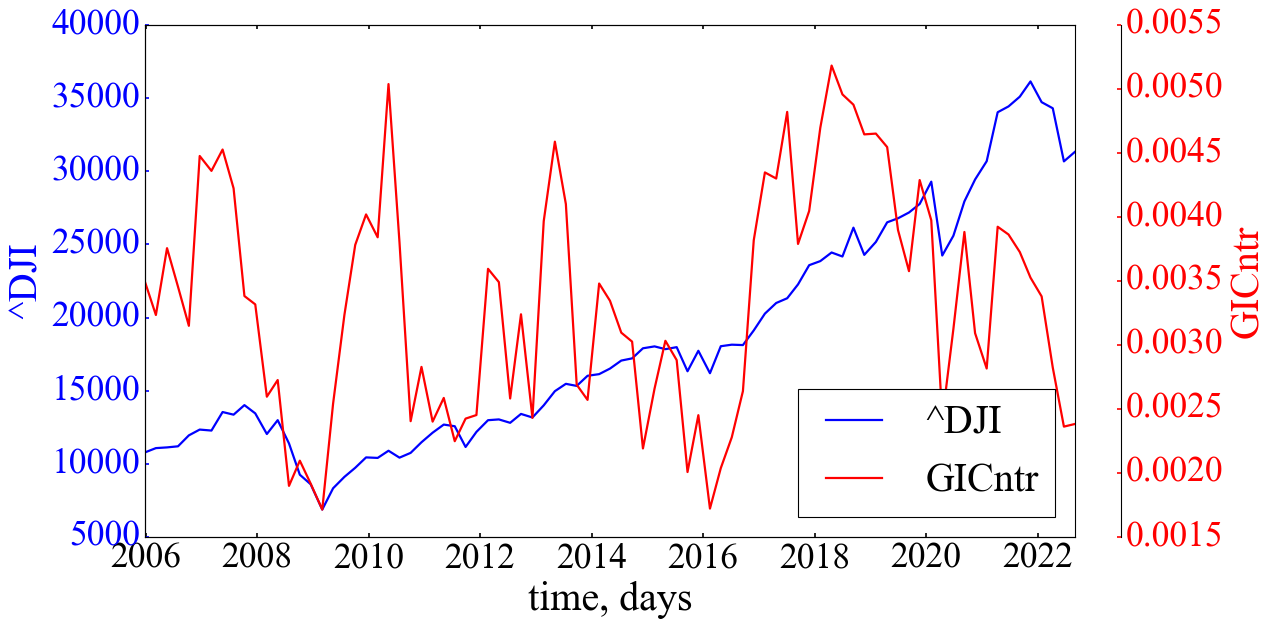

In [26]:
fig, ax = plt.subplots(1, 1)

ax2 = ax.twinx()

ax2.spines.right.set_position(("axes", 1.05))

p1, = ax.plot(time_ser.index[window:length:tstep], for_graph[window:length:tstep], "b-", label=fr"{symbol_for_graph_plot}")
p2, = ax2.plot(time_ser.index[window:length:tstep], GlobalInformationCentrality, "r-", label=r'GICntr')

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph_plot}")
ax2.set_ylabel(r'GICntr')

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax2.legend(handles=[p1, p2], loc='best')

plt.savefig(f"GlobalInformationCentrality, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality

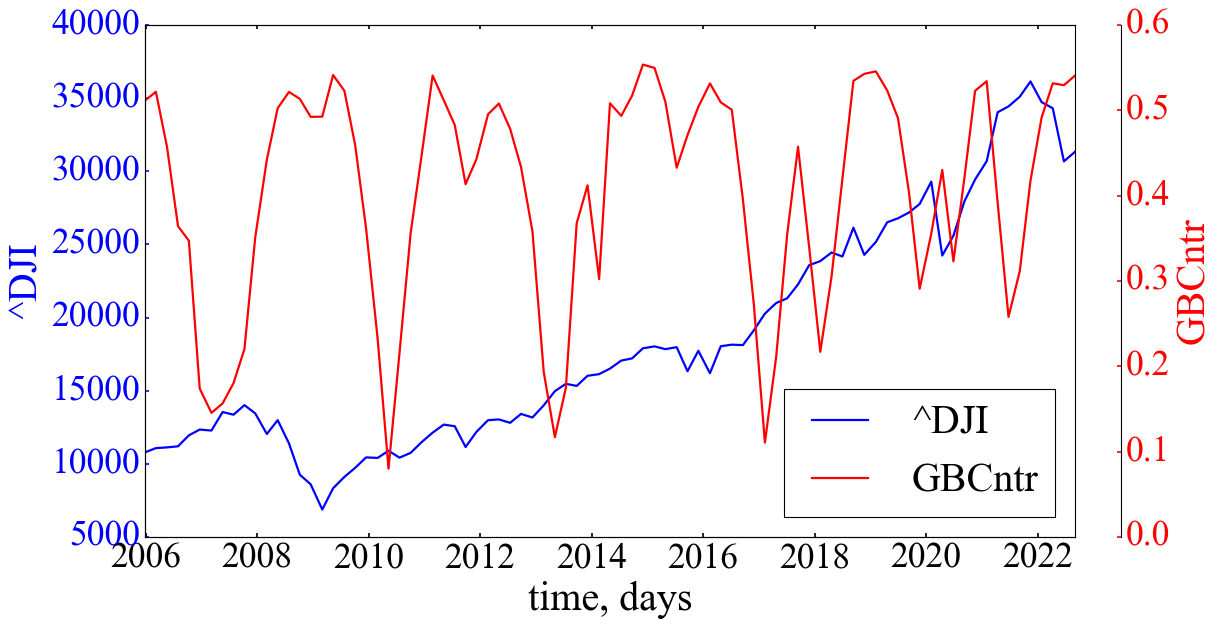

In [27]:
fig, ax = plt.subplots(1, 1)

ax2 = ax.twinx()

ax2.spines.right.set_position(("axes", 1.05))

p1, = ax.plot(time_ser.index[window:length:tstep], for_graph[window:length:tstep], "b-", label=fr"{symbol_for_graph_plot}")
p2, = ax2.plot(time_ser.index[window:length:tstep], GlobalBetweennessCentrality, "r-", label=r'GBCntr')

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph_plot}")
ax2.set_ylabel(r'GBCntr')

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax2.legend(handles=[p1, p2], loc='best')

plt.savefig(f"GlobalBetweennessCentrality, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.load_centrality.html#networkx.algorithms.centrality.load_centrality

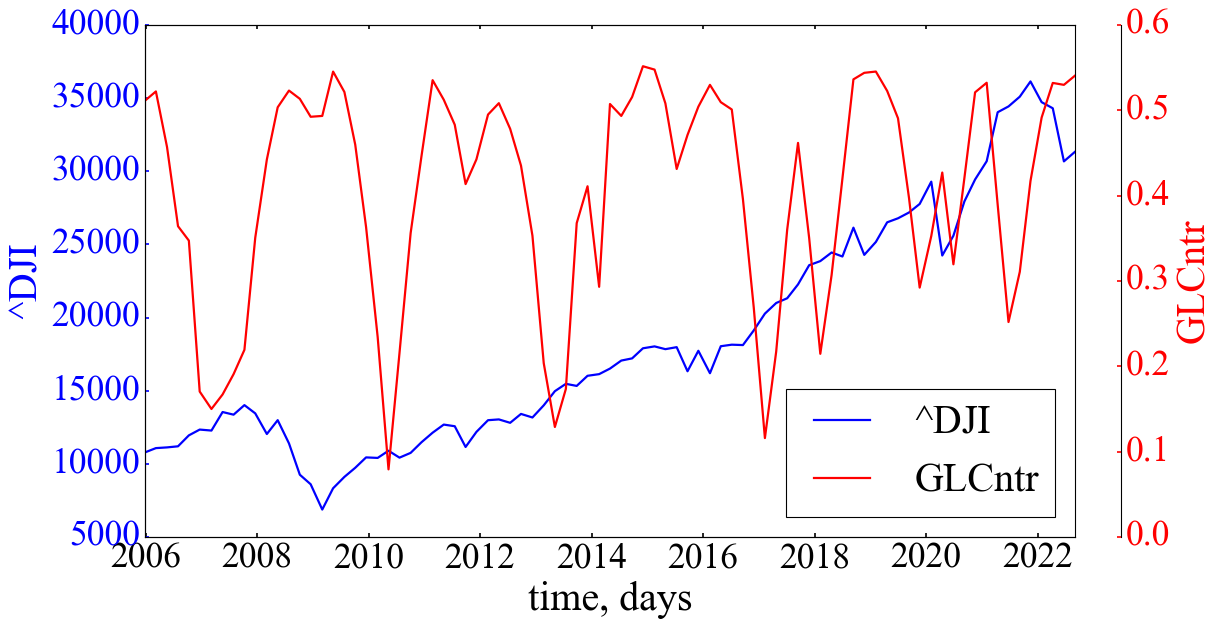

In [28]:
fig, ax = plt.subplots(1, 1)

ax2 = ax.twinx()

ax2.spines.right.set_position(("axes", 1.05))

p1, = ax.plot(time_ser.index[window:length:tstep], for_graph[window:length:tstep], "b-", label=fr"{symbol_for_graph_plot}")
p2, = ax2.plot(time_ser.index[window:length:tstep], GlobalLoadCentrality, "r-", label=r'GLCntr')

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph_plot}")
ax2.set_ylabel(r'GLCntr')

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax2.legend(handles=[p1, p2], loc='best')

plt.savefig(f"GlobalLoadCentrality, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.harmonic_centrality.html#networkx.algorithms.centrality.harmonic_centrality

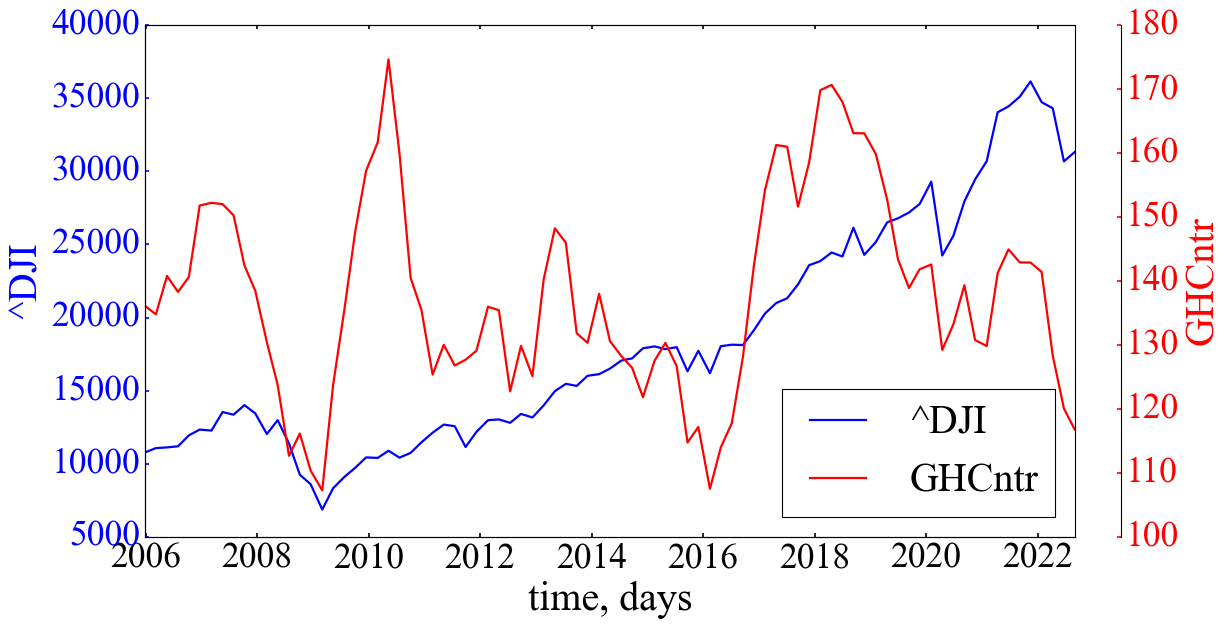

In [29]:
fig, ax = plt.subplots(1, 1)

ax2 = ax.twinx()

ax2.spines.right.set_position(("axes", 1.05))

p1, = ax.plot(time_ser.index[window:length:tstep], for_graph[window:length:tstep], "b-", label=fr"{symbol_for_graph_plot}")
p2, = ax2.plot(time_ser.index[window:length:tstep], GlobalHarmonicCentrality, "r-", label=r'GHCntr')

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph_plot}")
ax2.set_ylabel(r'GHCntr')

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax2.legend(handles=[p1, p2], loc='best')

plt.savefig(f"GlobalHarmonicCentrality, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

# In window (Topological)

## Assortativity

In [30]:
Assortativity = []

In [31]:
for i in tqdm(range(0,length-window,tstep)):
    fragm = time_ser.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm.diff()
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
    elif ret_type == 5: 
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        fragm = fragm.abs()
    elif ret_type == 6:
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values 
    
    if graph_type == 'classic':
        g_dir = NaturalVG(directed='left_to_right').build(fragm)
        nxg_dir = g_dir.as_networkx()
    elif graph_type == 'horizontal':
        g_dir = HorizontalVG(directed='left_to_right').build(fragm)
        nxg_dir = g_dir.as_networkx()
    else:
        g = recurrence_net(fragm, rec_thr=eps, rec_inc=eps_inc, dim=d_e, tau=tau, dist_type=dist)
        nxg_dir = nx.DiGraph(g)

    
    assort = nx.degree_pearson_correlation_coefficient(nxg_dir)

    Assortativity.append(assort)

100%|██████████| 85/85 [00:01<00:00, 64.28it/s]


In [32]:
np.savetxt(f"Assortativity_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", Assortativity)

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.degree_pearson_correlation_coefficient.html#networkx.algorithms.assortativity.degree_pearson_correlation_coefficient

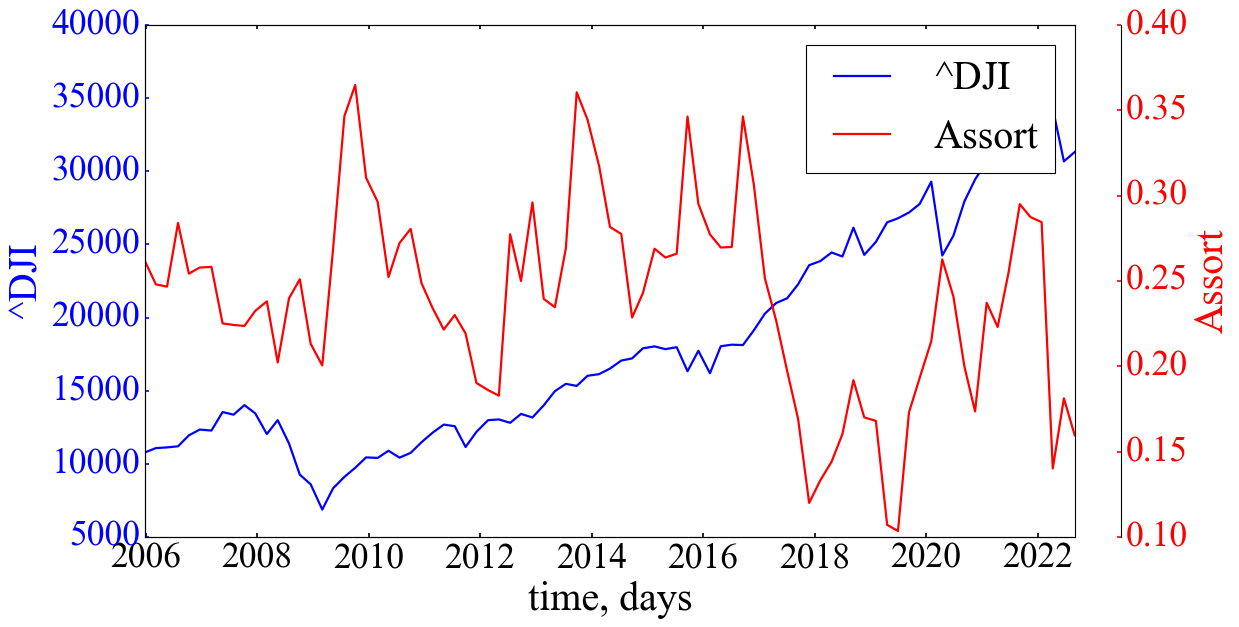

In [33]:
fig, ax = plt.subplots(1, 1)

ax2 = ax.twinx()

ax2.spines.right.set_position(("axes", 1.05))

p1, = ax.plot(time_ser.index[window:length:tstep], for_graph[window:length:tstep], "b-", label=fr"{symbol_for_graph_plot}")
p2, = ax2.plot(time_ser.index[window:length:tstep], Assortativity, "r-", label=r'Assort')

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph_plot}")
ax2.set_ylabel(r'Assort')

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax2.legend(handles=[p1, p2], loc='best')

plt.savefig(f"Assortativity, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

# In window (Topological)
## Clustering

In [34]:
Transitivity = []
AvgClustering = []
AvgSquareClustering = []

In [35]:
for i in tqdm(range(0,length-window,tstep)):
    fragm = time_ser.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm.diff()
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
    elif ret_type == 5: 
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        fragm = fragm.abs()
    elif ret_type == 6:
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values 
    
    if graph_type == 'classic':
        g = NaturalVG(directed=None).build(fragm)
        nxg = g.as_networkx()
    elif graph_type == 'horizontal':
        g = HorizontalVG(directed=None).build(fragm)
        nxg = g.as_networkx()
    else:
        g = recurrence_net(fragm, rec_thr=eps, rec_inc=eps_inc, dim=d_e, tau=tau, dist_type=dist)
        nxg = g

    trans = nx.transitivity(nxg)
    avg_clust = nx.average_clustering(nxg)
    avg_sqr_clust = np.mean(list(nx.square_clustering(nxg).values()))
    
    Transitivity.append(trans)
    AvgClustering.append(avg_clust)
    AvgSquareClustering.append(avg_sqr_clust)
    

100%|██████████| 85/85 [00:45<00:00,  1.89it/s]


In [36]:
np.savetxt(f"AvgClustering_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", AvgClustering)
np.savetxt(f"Transitivity_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", Transitivity)
np.savetxt(f"AvgSquareClustering_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", AvgSquareClustering)

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.average_clustering.html#networkx.algorithms.cluster.average_clustering

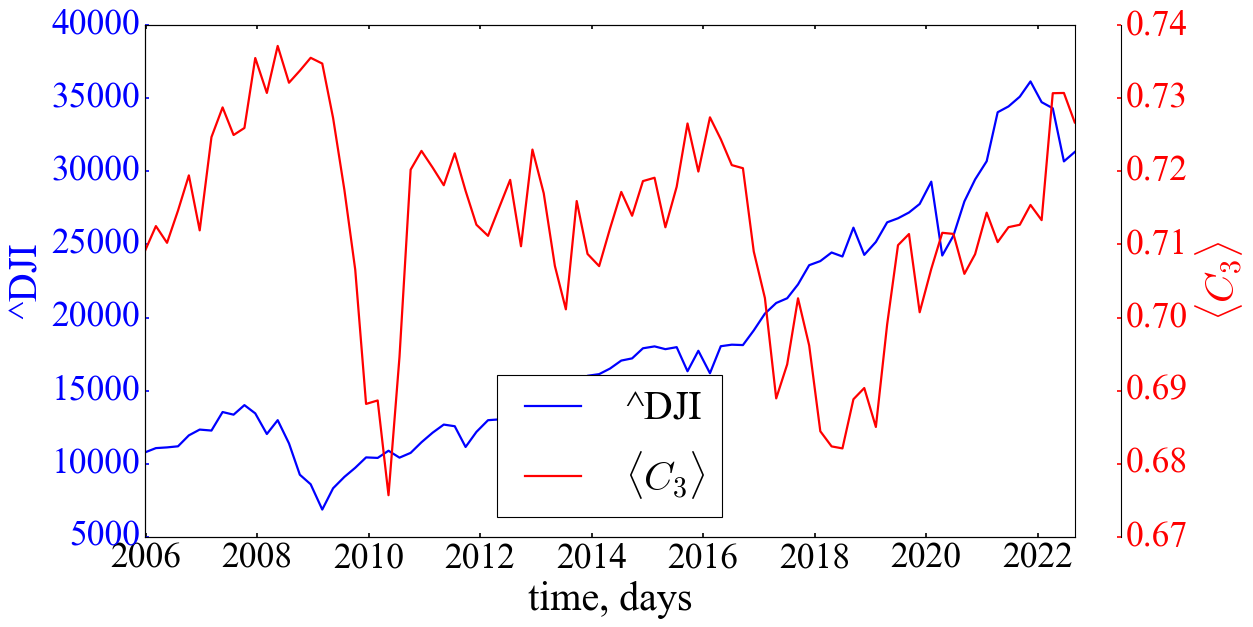

In [37]:
fig, ax = plt.subplots(1, 1)

ax2 = ax.twinx()

ax2.spines.right.set_position(("axes", 1.05))

p1, = ax.plot(time_ser.index[window:length:tstep], for_graph[window:length:tstep], "b-", label=fr"{symbol_for_graph_plot}")
p2, = ax2.plot(time_ser.index[window:length:tstep], AvgClustering, "r-", label=r'$\langle C_{3} \rangle$')

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph_plot}")
ax2.set_ylabel(r'$\langle C_{3} \rangle$')

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax2.legend(handles=[p1, p2], loc='best')

plt.savefig(f"AvgClustering, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.square_clustering.html#networkx.algorithms.cluster.square_clustering

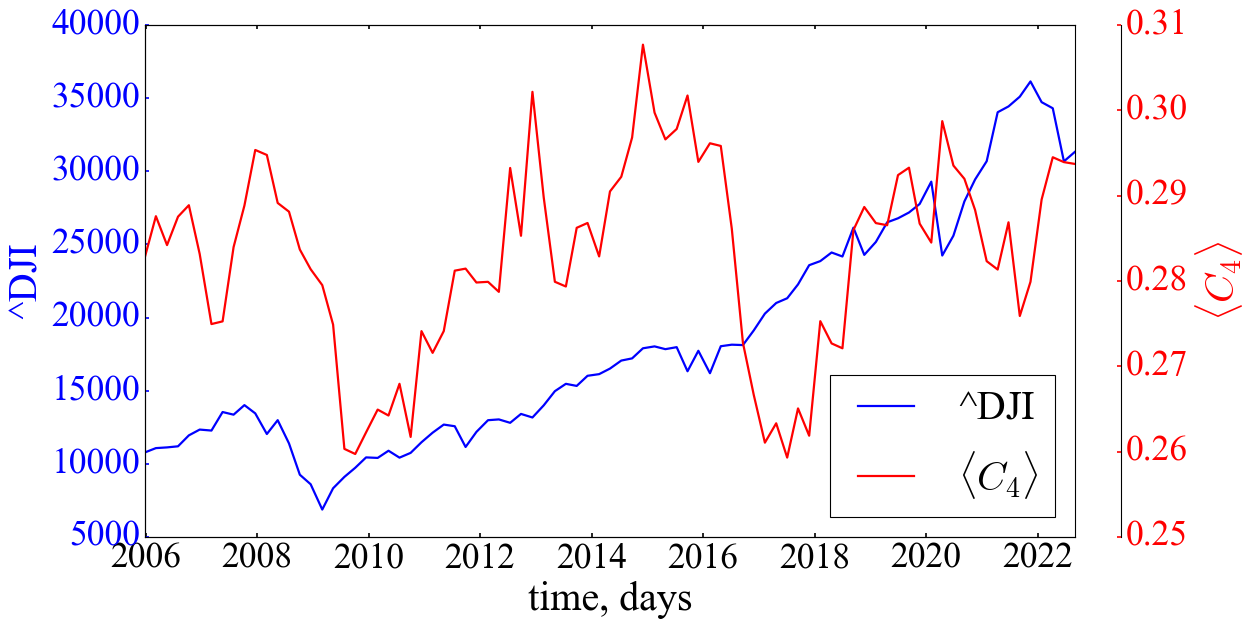

In [38]:
fig, ax = plt.subplots(1, 1)

ax2 = ax.twinx()

ax2.spines.right.set_position(("axes", 1.05))

p1, = ax.plot(time_ser.index[window:length:tstep], for_graph[window:length:tstep], "b-", label=fr"{symbol_for_graph_plot}")
p2, = ax2.plot(time_ser.index[window:length:tstep], AvgSquareClustering, "r-", label=r'$\langle C_{4} \rangle$')

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph_plot}")
ax2.set_ylabel(r'$\langle C_{4} \rangle$')

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax2.legend(handles=[p1, p2], loc='best')

plt.savefig(f"AvgSquareClustering, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.transitivity.html#networkx.algorithms.cluster.transitivity

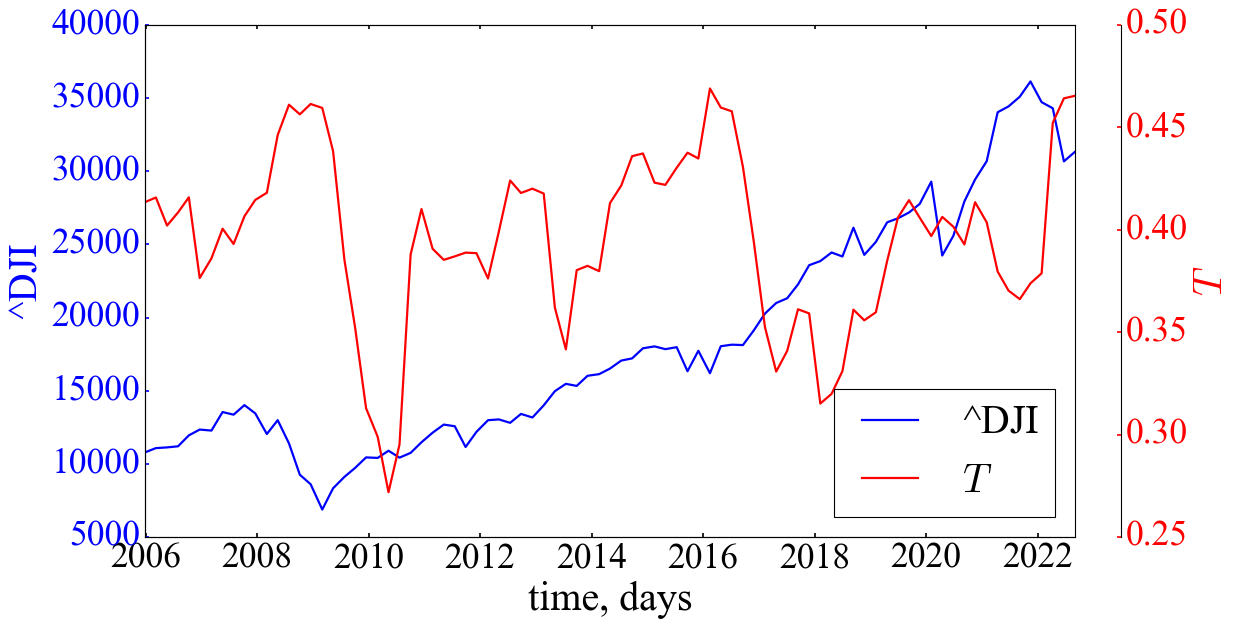

In [39]:
fig, ax = plt.subplots(1, 1)

ax2 = ax.twinx()

ax2.spines.right.set_position(("axes", 1.05))

p1, = ax.plot(time_ser.index[window:length:tstep], for_graph[window:length:tstep], "b-", label=fr"{symbol_for_graph_plot}")
p2, = ax2.plot(time_ser.index[window:length:tstep], Transitivity, "r-", label=r'$T$')

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph_plot}")
ax2.set_ylabel(r'$T$')

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax2.legend(handles=[p1, p2], loc='best')

plt.savefig(f"Transitivity, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

# In window (Topological)

## Connectivity

In [40]:
AvgDegreeConnectivity = []

In [41]:
for i in tqdm(range(0,length-window,tstep)):
    fragm = time_ser.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm.diff()
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
    elif ret_type == 5: 
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        fragm = fragm.abs()
    elif ret_type == 6:
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values 
    
    if graph_type == 'classic':
        g_dir = NaturalVG(directed='left_to_right').build(fragm)
        nxg_dir = g_dir.as_networkx()
    elif graph_type == 'horizontal':
        g_dir = HorizontalVG(directed='left_to_right').build(fragm)
        nxg_dir = g_dir.as_networkx()
    else:
        g = recurrence_net(fragm, rec_thr=eps, rec_inc=eps_inc, dim=d_e, tau=tau, dist_type=dist)
        nxg_dir = nx.DiGraph(g)
    

    avg_deg_con = np.mean(list(nx.average_degree_connectivity(nxg_dir, source="out", target="in").values()))
    
    AvgDegreeConnectivity.append(avg_deg_con)

100%|██████████| 85/85 [00:00<00:00, 98.75it/s] 


In [42]:
np.savetxt(f"AvgDegreeConnectivity_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", AvgDegreeConnectivity)

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.average_degree_connectivity.html#networkx.algorithms.assortativity.average_degree_connectivity

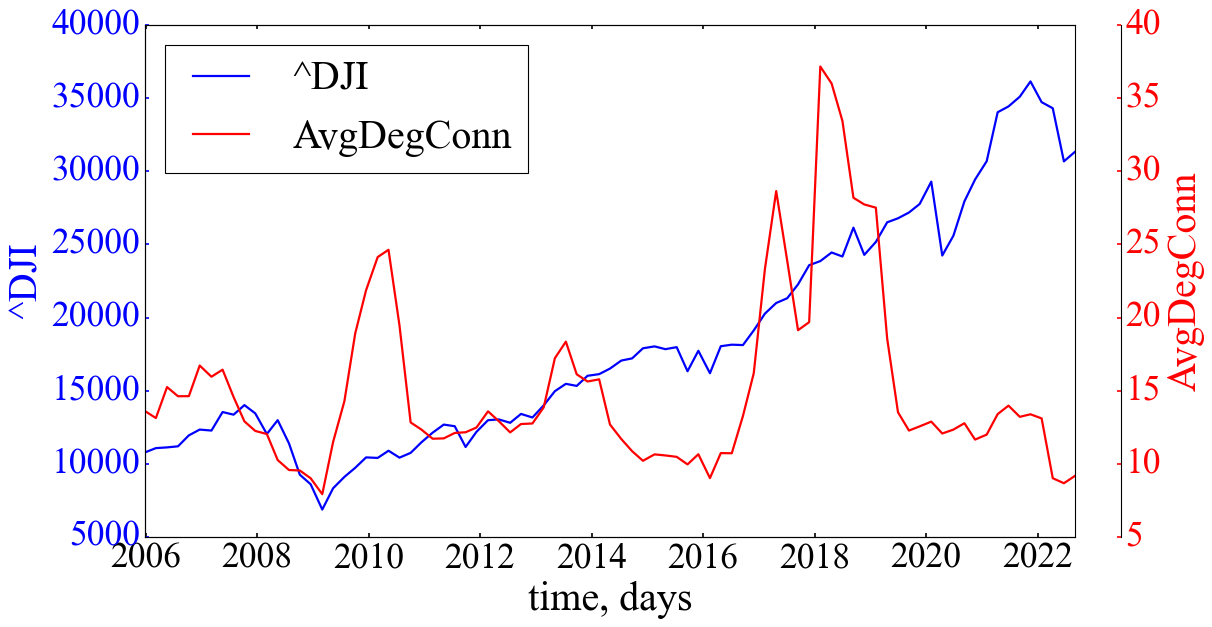

In [43]:
fig, ax = plt.subplots(1, 1)

ax2 = ax.twinx()

ax2.spines.right.set_position(("axes", 1.05))

p1, = ax.plot(time_ser.index[window:length:tstep], for_graph[window:length:tstep], "b-", label=fr"{symbol_for_graph_plot}")
p2, = ax2.plot(time_ser.index[window:length:tstep], AvgDegreeConnectivity, "r-", label=r'AvgDegConn')

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph_plot}")
ax2.set_ylabel(r'AvgDegConn')

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax2.legend(handles=[p1, p2], loc='best')

plt.savefig(f"AvgDegreeConnectivity, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

# In window (Topological)
## Edges 

In [44]:
Density = []

In [45]:
for i in tqdm(range(0,length-window,tstep)):
    fragm = time_ser.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm.diff()
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
    elif ret_type == 5: 
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        fragm = fragm.abs()
    elif ret_type == 6:
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values 
    
    if graph_type == 'classic':
        g = NaturalVG(directed=None).build(fragm)
        nxg = g.as_networkx()
    elif graph_type == 'horizontal':
        g = HorizontalVG(directed=None).build(fragm)
        nxg = g.as_networkx()
    else:
        g = recurrence_net(fragm, rec_thr=eps, rec_inc=eps_inc, dim=d_e, tau=tau, dist_type=dist)
        nxg = g
    
    dens = nx.density(nxg)
   

    Density.append(dens)

100%|██████████| 85/85 [00:00<00:00, 220.16it/s]


In [46]:
np.savetxt(f"Density_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", Density)

https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.density.html#density

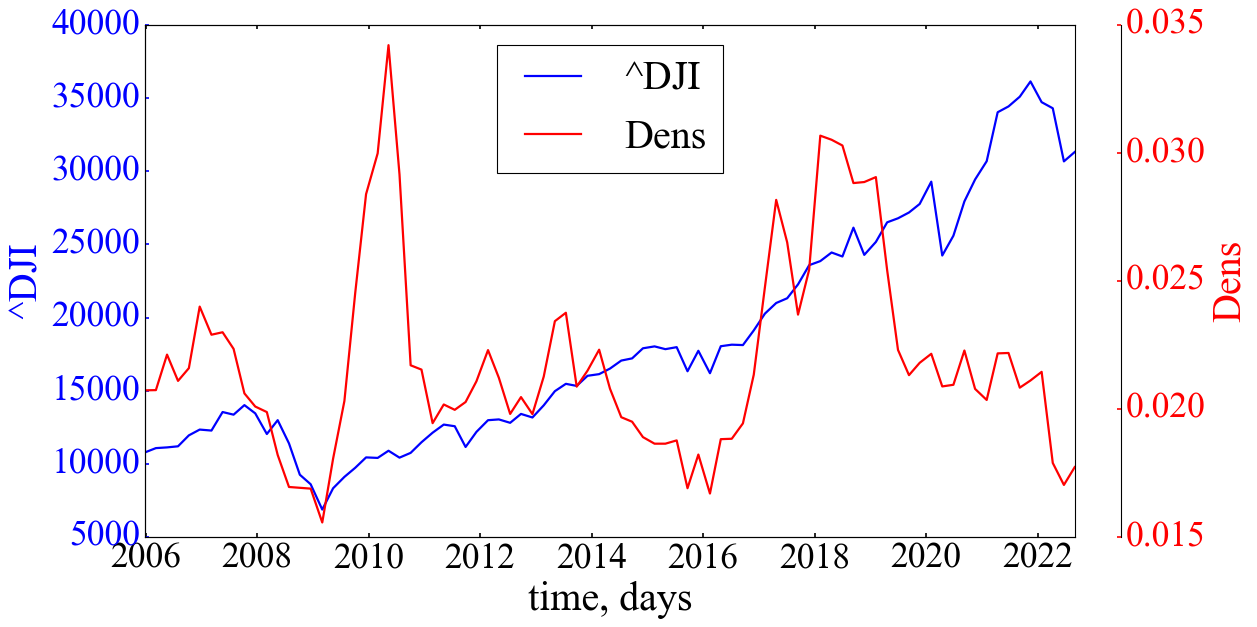

In [47]:
fig, ax = plt.subplots(1, 1)

ax2 = ax.twinx()

ax2.spines.right.set_position(("axes", 1.05))

p1, = ax.plot(time_ser.index[window:length:tstep], for_graph[window:length:tstep], "b-", label=fr"{symbol_for_graph_plot}")
p2, = ax2.plot(time_ser.index[window:length:tstep], Density, "r-", label=r'Dens')

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph_plot}")
ax2.set_ylabel(r'Dens')

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax2.legend(handles=[p1, p2], loc='best')

plt.savefig(f"Density, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

# In window (Topological)
## Distance measures

In [48]:
Diameter = []
Radius = []

In [49]:
for i in tqdm(range(0,length-window,tstep)):
    fragm = time_ser.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm.diff()
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
    elif ret_type == 5: 
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        fragm = fragm.abs()
    elif ret_type == 6:
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values 
    
    if graph_type == 'classic':
        g = NaturalVG(directed=None).build(fragm)
        nxg = g.as_networkx()
    elif graph_type == 'horizontal':
        g = HorizontalVG(directed=None).build(fragm)
        nxg = g.as_networkx()
    else:
        g = recurrence_net(fragm, rec_thr=eps, rec_inc=eps_inc, dim=d_e, tau=tau, dist_type=dist)
        nxg = g
    
    diameter = nx.diameter(nxg)
    rad = nx.radius(nxg)
    
    Diameter.append(diameter)
    Radius.append(rad)

100%|██████████| 85/85 [01:00<00:00,  1.40it/s]


In [50]:
np.savetxt(f"Diameter_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", Diameter)
np.savetxt(f"Radius_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", Radius)

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html#diameter

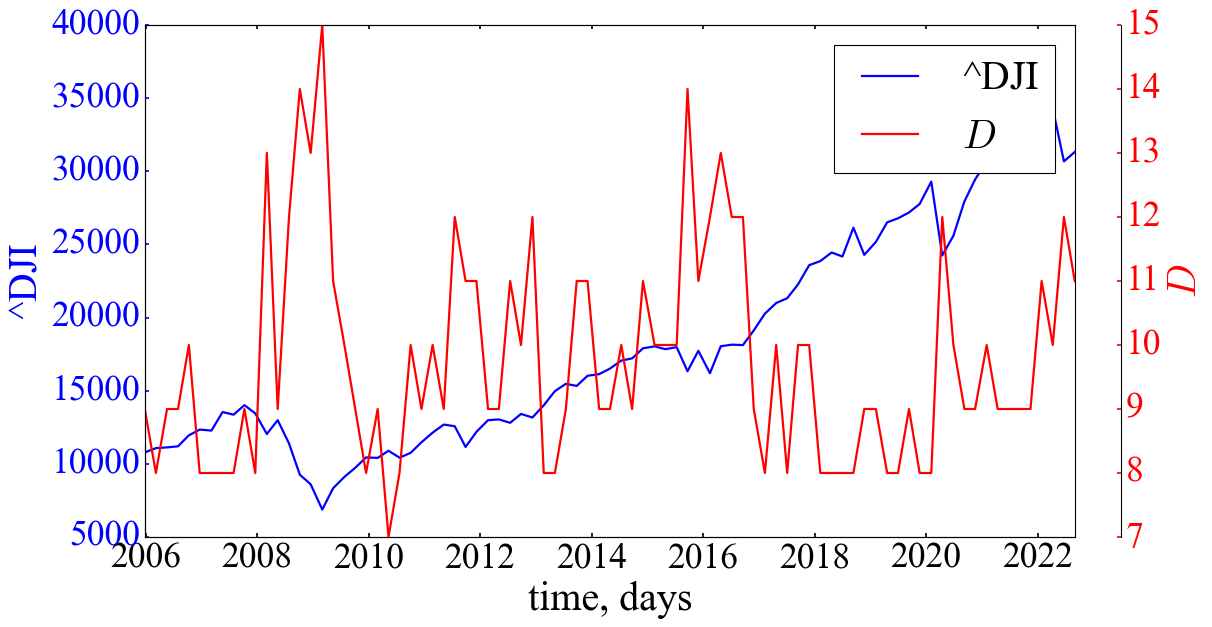

In [51]:
fig, ax = plt.subplots(1, 1)

ax2 = ax.twinx()

ax2.spines.right.set_position(("axes", 1.05))

p1, = ax.plot(time_ser.index[window:length:tstep], for_graph[window:length:tstep], "b-", label=fr"{symbol_for_graph_plot}")
p2, = ax2.plot(time_ser.index[window:length:tstep], Diameter, "r-", label=r'$D$')

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph_plot}")
ax2.set_ylabel(r'$D$')

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax2.legend(handles=[p1, p2], loc='best')

plt.savefig(f"Diameter, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.distance_measures.radius.html#radius

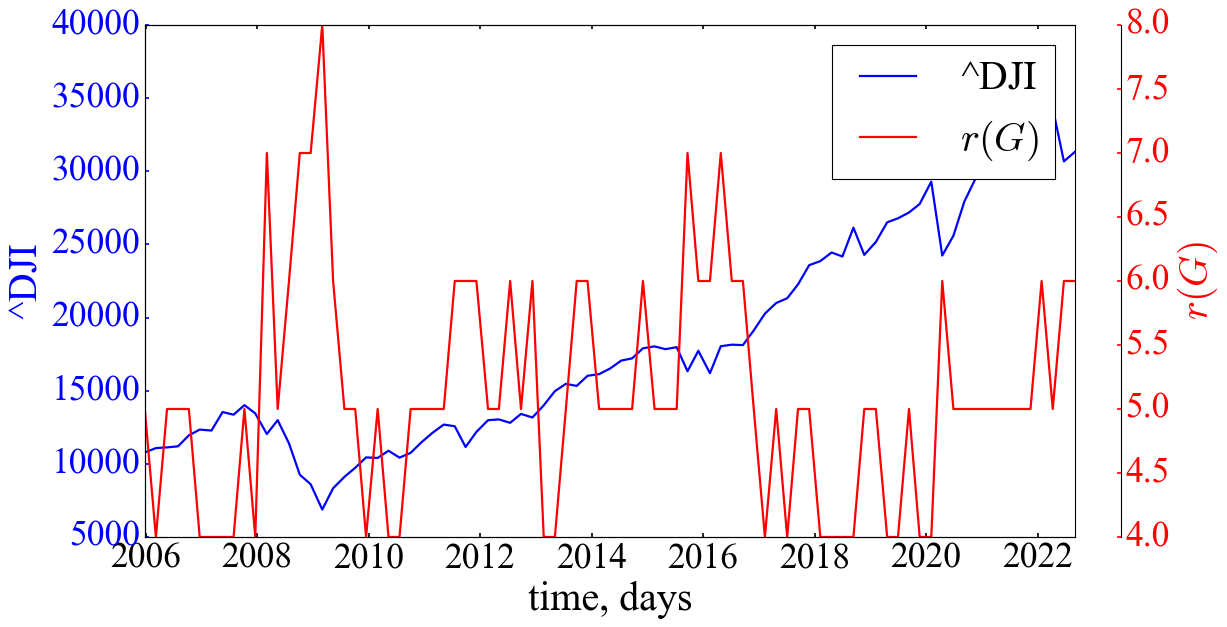

In [52]:
fig, ax = plt.subplots(1, 1)

ax2 = ax.twinx()

ax2.spines.right.set_position(("axes", 1.05))

p1, = ax.plot(time_ser.index[window:length:tstep], for_graph[window:length:tstep], "b-", label=fr"{symbol_for_graph_plot}")
p2, = ax2.plot(time_ser.index[window:length:tstep], Radius, "r-", label=r'$r(G)$')

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph_plot}")
ax2.set_ylabel(r'$r(G)$')

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax2.legend(handles=[p1, p2], loc='best')

plt.savefig(f"Radius, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

# In window (Topological)
## Efficiency

In [53]:
LocalEfficiency = []
GlobalEfficiency = []

In [54]:
for i in tqdm(range(0,length-window,tstep)):
    fragm = time_ser.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm.diff()
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
    elif ret_type == 5: 
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        fragm = fragm.abs()
    elif ret_type == 6:
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values 
    
    if graph_type == 'classic':
        g = NaturalVG(directed=None).build(fragm)
        nxg = g.as_networkx()
    elif graph_type == 'horizontal':
        g = HorizontalVG(directed=None).build(fragm)
        nxg = g.as_networkx()
    else:
        g = recurrence_net(fragm, rec_thr=eps, rec_inc=eps_inc, dim=d_e, tau=tau, dist_type=dist)
        nxg = g
    
    local_eff = nx.local_efficiency(nxg)
    glob_eff = nx.global_efficiency(nxg)
    
    LocalEfficiency.append(local_eff)
    GlobalEfficiency.append(glob_eff)

100%|██████████| 85/85 [02:48<00:00,  1.98s/it]


In [55]:
np.savetxt(f"LocalEfficiency_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", LocalEfficiency)
np.savetxt(f"GlobalEfficiency_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", GlobalEfficiency)

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.efficiency_measures.local_efficiency.html#networkx.algorithms.efficiency_measures.local_efficiency

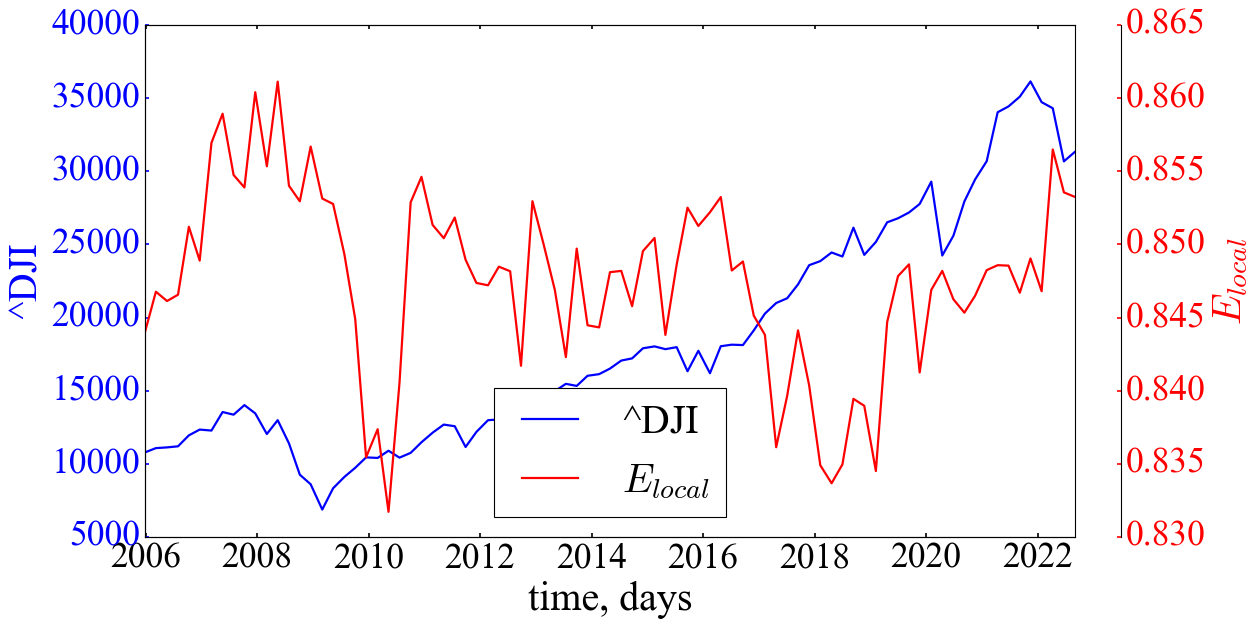

In [56]:
fig, ax = plt.subplots(1, 1)

ax2 = ax.twinx()

ax2.spines.right.set_position(("axes", 1.05))

p1, = ax.plot(time_ser.index[window:length:tstep], for_graph[window:length:tstep], "b-", label=fr"{symbol_for_graph_plot}")
p2, = ax2.plot(time_ser.index[window:length:tstep], LocalEfficiency, "r-", label=r'$E_{local}$')

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph_plot}")
ax2.set_ylabel(r'$E_{local}$')

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax2.legend(handles=[p1, p2], loc='best')

plt.savefig(f"LocalEfficiency, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.efficiency_measures.global_efficiency.html#networkx.algorithms.efficiency_measures.global_efficiency

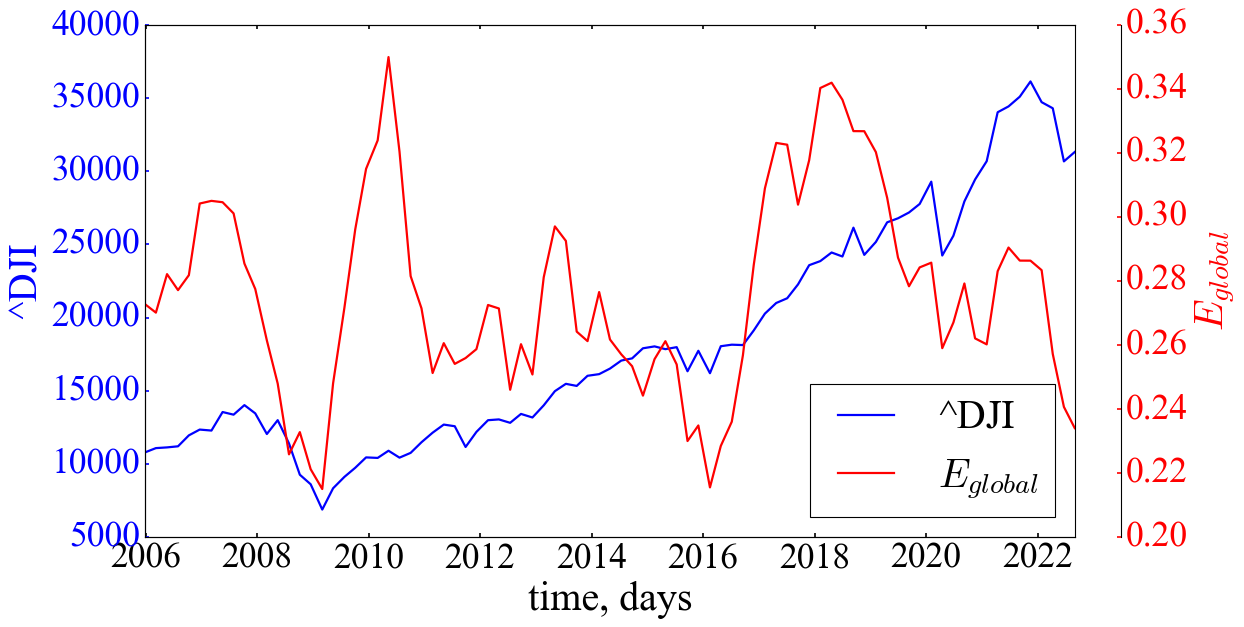

In [57]:
fig, ax = plt.subplots(1, 1)

ax2 = ax.twinx()

ax2.spines.right.set_position(("axes", 1.05))

p1, = ax.plot(time_ser.index[window:length:tstep], for_graph[window:length:tstep], "b-", label=fr"{symbol_for_graph_plot}")
p2, = ax2.plot(time_ser.index[window:length:tstep], GlobalEfficiency, "r-", label=r'$E_{global}$')

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph_plot}")
ax2.set_ylabel(r'$E_{global}$')

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax2.legend(handles=[p1, p2], loc='best')

plt.savefig(f"GlobalEfficiency, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()

# In window (Topological)
## Shortest path

In [58]:
AvgPathLength = []

In [59]:
for i in tqdm(range(0,length-window,tstep)):
    fragm = time_ser.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm.diff()
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
    elif ret_type == 5: 
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        fragm = fragm.abs()
    elif ret_type == 6:
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values 
    
    if graph_type == 'classic':
        g = NaturalVG(directed=None).build(fragm)
        nxg = g.as_networkx()
    elif graph_type == 'horizontal':
        g = HorizontalVG(directed=None).build(fragm)
        nxg = g.as_networkx()
    else:
        g = recurrence_net(fragm, rec_thr=eps, rec_inc=eps_inc, dim=d_e, tau=tau, dist_type=dist)
        nxg = g
    

    avg_path_len = nx.average_shortest_path_length(nxg)
   
    AvgPathLength.append(avg_path_len)

100%|██████████| 85/85 [00:31<00:00,  2.73it/s]


In [60]:
np.savetxt(f"AvgPathLength_symbol={symbol}_wind={window}_step={tstep}_seriestype={ret_type}_graph_type={graph_type}.txt", AvgPathLength)

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.average_shortest_path_length.html

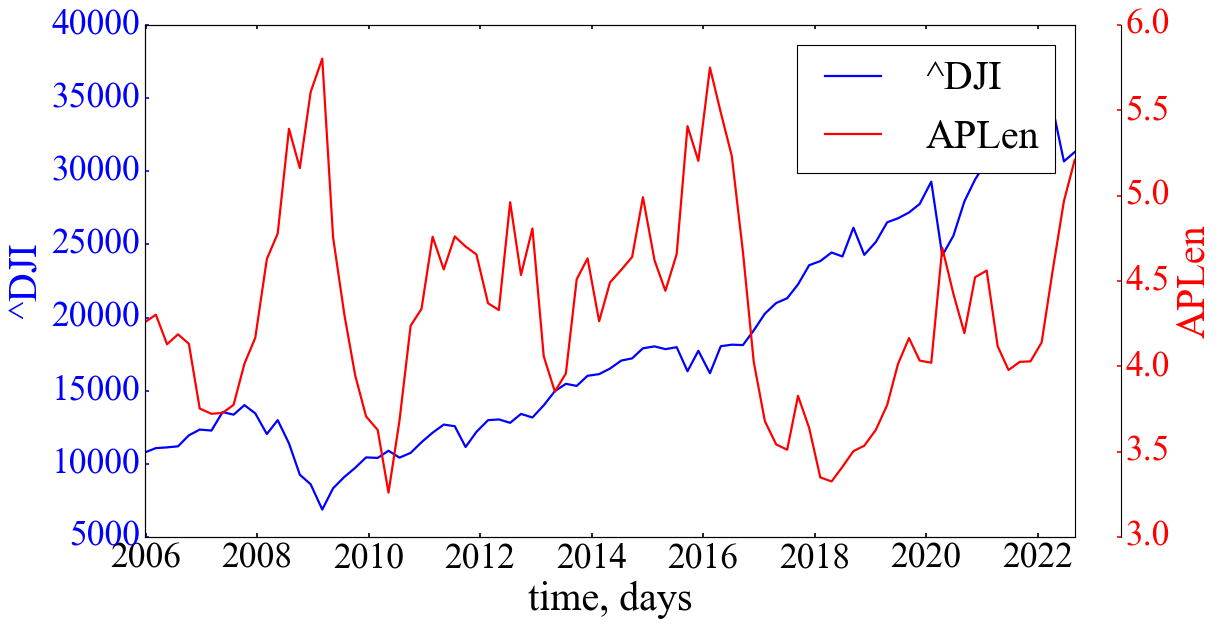

In [61]:
fig, ax = plt.subplots(1, 1)

ax2 = ax.twinx()

ax2.spines.right.set_position(("axes", 1.05))

p1, = ax.plot(time_ser.index[window:length:tstep], for_graph[window:length:tstep], "b-", label=fr"{symbol_for_graph_plot}")
p2, = ax2.plot(time_ser.index[window:length:tstep], AvgPathLength, "r-", label=r'APLen')

ax.set_xlabel(xlabel)
ax.set_ylabel(fr"{symbol_for_graph_plot}")
ax2.set_ylabel(r'APLen')

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax2.legend(handles=[p1, p2], loc='best')

plt.savefig(f"AvgPathLength, symbol={symbol}, wind={window}, step={tstep}, seriestype={ret_type}, graph_type={graph_type}.jpg")
plt.show()